In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils

In [24]:
def decision(avg, avg_ctr):
    if avg <= 100:
        return "1"
    else:
        return conflict(avg_ctr)

def conflict(avg):
    if avg <= 130:
        return "2"
    else:
        return "5"

In [25]:
def color(decision):
    if decision == 5:
        return (0,255,0)
    elif decision == 2:
        return (255,0,0)
    else:
        return (0,0,255)

In [26]:
def calculate_average_distance(image):
    distance_list = []
    for row in image:
        for (b, g, r) in row:
            if(b != 0 and g != 0 and r != 0):
                
                # Calculate distance
                value = abs(int(b) - int(g)) + abs(int(b) - int(r)) + abs(int(r) - int(g))

                # Append calculated value
                distance_list.append(value)

    # Cast list to numpy array
    distance_list = np.array(distance_list, dtype="int")

    # Calculate average
    avg = np.average(distance_list)
    return avg

In [27]:
def contours(img):
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (11,11), 0)
    
    _, thresh = cv2.threshold(blur,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = np.ones((5,5), np.uint8)
    eroded = cv2.erode(thresh, kernel, iterations=2)
    dilated = cv2.dilate(eroded, kernel, iterations=2)
    
    contours = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, 
                                       cv2.CHAIN_APPROX_NONE)

    cnts = imutils.grab_contours(contours)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    return img_color, cnts

def cut(img, cnts):
    imgs = []
    centers = []
    text = []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for cnt in cnts:
        mask = np.zeros(gray.shape, np.uint8)
        new = cv2.drawContours(mask, [cnt], 0, 255, -1)
        new = cv2.bitwise_and(img, img, mask=mask)
        
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
        (x,y) = np.where(mask==255)
        (x1,y1) = (np.min(x), np.min(y))
        (x2,y2) = (np.max(x), np.max(y))
        crop_img = img[x1:x2+1, y1:y2+1]
        
        x1 = int(crop_img.shape[0] / 4)
        x2 = int(3 * crop_img.shape[0] / 4)
        y1 = int(crop_img.shape[1] / 4)
        y2 = int(3 * crop_img.shape[1] / 4)
        
        centrum = crop_img[x1:x2, y1:y2]
        
        imgs.append(crop_img)
        centers.append(centrum)
        text.append((cX, cY))
        
    return imgs, centers, text

In [28]:
# Circles function

def f_circle(img, cnts):
    ctr = []
    i=0
    for cnt in cnts:
                    approx = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
                    vert = len(approx)
                    if(3 < vert):
                        area = cv2.contourArea(cnt)
                        #print(area,i)
                        i+=1
                        if (500 < area <200000):
                            _, r = cv2.minEnclosingCircle(cnt)
                            r = r * 0.95
                            circleArea = r * r * np.pi
                            if(area/circleArea > 0.60):
                                ctr.append(cnt)

    return ctr

def circle(img, cnts):
    circles = f_circle(img,cnts)
    
    imgs, centers, text  = cut(img, circles)
    
    suma = []
    for j in range(len(imgs)):
        avg = calculate_average_distance(imgs[j])
        #print("Avg", avg)
        
        center_avg = calculate_average_distance(centers[j])
        #print("Avg_ctr", center_avg)
        
        dec = int(decision(avg, center_avg))
        #print("Moneta", decyzja)
        
        suma.append(dec)
        
        cv2.drawContours(img, circles[j], -1, color(dec), 10)
        cv2.putText(img, str(decyzja)+" PLN", text[j], cv2.FONT_HERSHEY_SIMPLEX, 1.2, color(dec), 3)
    
    return suma

In [29]:
def total_cost(sum1,sum2):
    suma = 0
    for i in range(len(sum1)):
        suma += sum1[i]
    for j in range(len(sum2)):
        suma += sum2[j]
    
    return suma

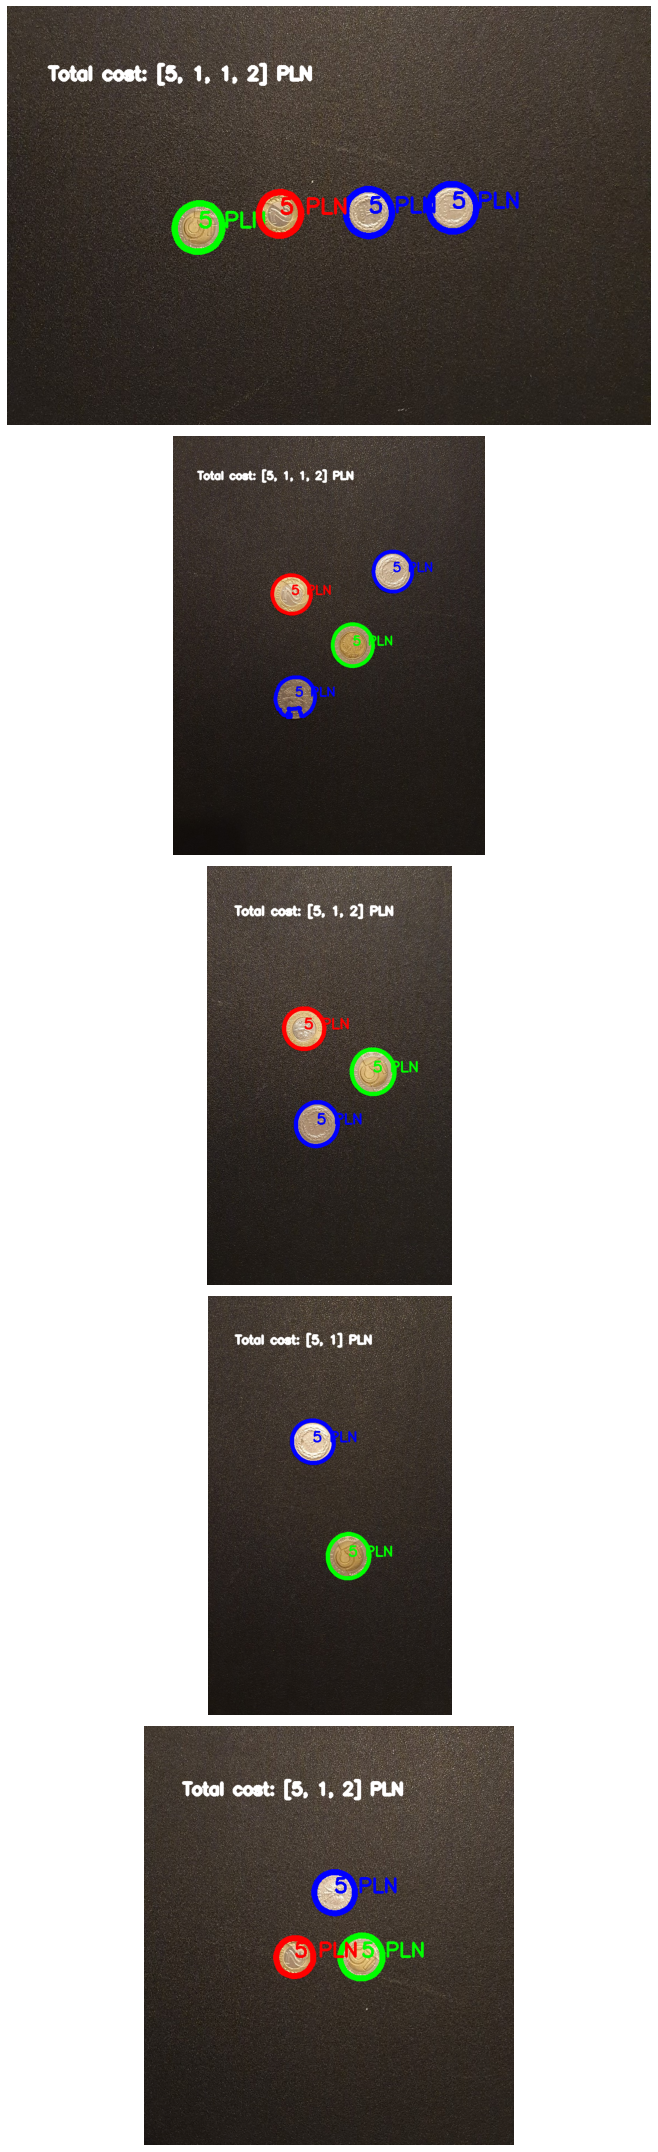

In [30]:
# Main

tab = ["c1.jpg","c2.jpg","c3.jpg","c4.jpg", "c5.jpg"]
#tab = ["m1.jpg","m2.jpg","m3.jpg","m4.jpg","m5.jpg",
#       "m6.jpg","m7.jpg","m8.jpg","m9.jpg","m10.jpg",
#       "m11.jpg","m12.jpg","m13.jpg","m14.jpg","m15.jpg",
#       "m16.jpg","m17.jpg","m18.jpg","m19.jpg","m20.jpg"]
#tab = ["b1.jpg","b2.jpg","b3.jpg","b4.jpg", "b5.jpg"]
#tab = ["mix1.jpg","mix2.jpg","mix3.jpg","mix4.jpg", "mix5.jpg"]
#tab = ["all1.jpg","all2.jpg","all3.jpg","all4.jpg", "all5.jpg"]

fig = plt.figure(figsize = (30,30))

for i in range(len(tab)):
    img = cv2.imread(tab[i])

    img, cnts = contours(img)
    
    circle_sum = circle(img, cnts)
    
    cv2.putText(img, "Total cost: "+str(circle_sum)+" PLN", (70,125), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 5)
       
    fig.add_subplot(5, 1, i + 1)
    plt.imshow(img)
    plt.axis('off')
    
fig.tight_layout()